# Project: AI Assistant Football Coach Agent - MDP vs Q-Learning
Name: Miraaj Chaudhry

# Import necessary packages
Import pandas, numpy, and matplotlib as all three will help in data exploration and data cleaning

In [2]:
import pandas as pd # for reading in analyzing data
import numpy as np # for reorganizing and analyzing data
import matplotlib as plt # for plotting data

# Explore Data
Explore data to get a better understanding of what the data represents and how important variables changed over the dataset.

In [5]:
# read in data
data = pd.read_csv('pbp-2024.csv')

# see column names and how many non-null data points there are
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53283 entries, 0 to 53282
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   GameId                          53283 non-null  int64  
 1   GameDate                        53283 non-null  object 
 2   Quarter                         53283 non-null  int64  
 3   Minute                          53283 non-null  int64  
 4   Second                          53283 non-null  int64  
 5   OffenseTeam                     53283 non-null  object 
 6   DefenseTeam                     53283 non-null  object 
 7   Down                            53283 non-null  int64  
 8   ToGo                            53283 non-null  int64  
 9   YardLine                        53283 non-null  int64  
 10  Unnamed: 10                     0 non-null      float64
 11  SeriesFirstDown                 53283 non-null  int64  
 12  Unnamed: 12                     

In [6]:
# see which formation was used the most
data['Formation'].describe()

count       52415
unique          6
top       SHOTGUN
freq        22416
Name: Formation, dtype: object

Formation
FIELD GOAL            1162
NO HUDDLE              676
NO HUDDLE SHOTGUN     4132
PUNT                  2104
SHOTGUN              22416
UNDER CENTER         21925
Name: Sum, dtype: int64


<Axes: ylabel='Sum'>

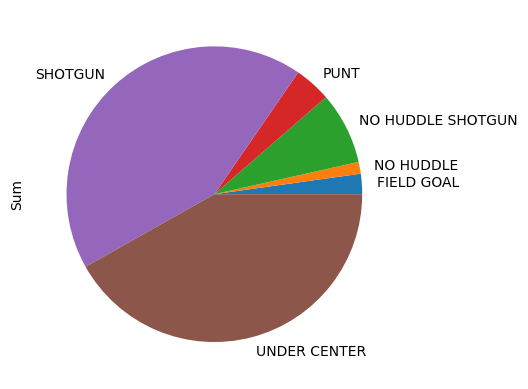

In [7]:
# see how much each formation was used
formations = pd.DataFrame(data['Formation'])
formations['Sum'] = 1
formations = formations.groupby(['Formation'])['Sum'].sum()
print(formations)
formations.plot(kind='pie')

In [8]:
# see which play type was used the most
data['PlayType'].describe()

count     47684
unique       16
top        PASS
freq      19551
Name: PlayType, dtype: object

In [9]:
plays = pd.DataFrame(data[['Formation', 'PlayType']])
plays['Sum'] = 1
plays = plays.groupby(['Formation', 'PlayType'])['Sum'].sum()
plays

Formation          PlayType            
FIELD GOAL         FIELD GOAL               1162
NO HUDDLE          CLOCK STOP                 79
                   FUMBLES                     4
                   NO PLAY                    18
                   PASS                      137
                   QB KNEEL                    1
                   RUSH                      410
                   SACK                       12
                   SCRAMBLE                   15
NO HUDDLE SHOTGUN  FUMBLES                    12
                   NO PLAY                    94
                   PASS                     2622
                   PENALTY                     1
                   RUSH                     1012
                   SACK                      194
                   SCRAMBLE                  193
PUNT               PUNT                     2104
SHOTGUN            EXCEPTION                   1
                   FUMBLES                    67
                   NO PLAY   

One thing that stands out from this data is the fact that timeouts occurred only when the offense lined up under center. Let's do a deeper analysis to figure out if this is an error as it seems to unrealistic

In [10]:
to = pd.DataFrame(data[data['PlayType'] == 'TIMEOUT'][['PlayType', 'Formation']])
to['Sum'] = 1
to = to.groupby(['Formation'])['Sum'].sum()
to

Formation
UNDER CENTER    2118
Name: Sum, dtype: int64

After grouping the data by play type and counting timeouts in the data, we get the same result as earlier. This means that this wild occurrence is correct, the author of the dataset made all timeouts count as under center by default, or there is an error this column. More research may need to be done to determine this. However, since our project as of now will not deal with timeouts, we will continue to use this dataset. If timeouts are to be used in the future, more research and analysis will be needed most likely.

In [11]:
# find how many touchdowns and turnovers occurred over the season
print("Total Touchdowns:", data['IsTouchdown'].sum())
print("Total Turnovers:", data['IsFumble'].sum() + data['IsInterception'].sum())

Total Touchdowns: 1591
Total Turnovers: 1128


In [12]:
# make a data frame that illustrates each team's total touchdowns
# IMPORTANT: This data will NOT exclude TDs taken away due to penalties or challenges

# make new data frame with just offensive team and touchdowns
by_team = pd.DataFrame(data[['OffenseTeam', 'IsTouchdown', 'IsInterception']])
# group data by team and combine touchdown totals
new = by_team.groupby(['OffenseTeam'], as_index=False)[['IsTouchdown', 'IsInterception']].sum()
# print result in ascending order
print(new.sort_values(by='IsTouchdown'))

   OffenseTeam  IsTouchdown  IsInterception
8          DAL           34              16
14         JAX           35              15
19         MIA           36              12
18          LV           36              18
7          CLE           38              23
21          NE           38              11
5          CHI           39               8
23         NYG           40              17
12         HOU           42              16
4          CAR           43              17
16          LA           43              12
26         PIT           44               7
17         LAC           44               8
9          DEN           45              13
1          ATL           45              19
22          NO           46              13
27         SEA           46              17
30         TEN           46              22
0          ARI           47              12
13         IND           47              21
24         NYJ           48              12
28          SF           49     

<Axes: >

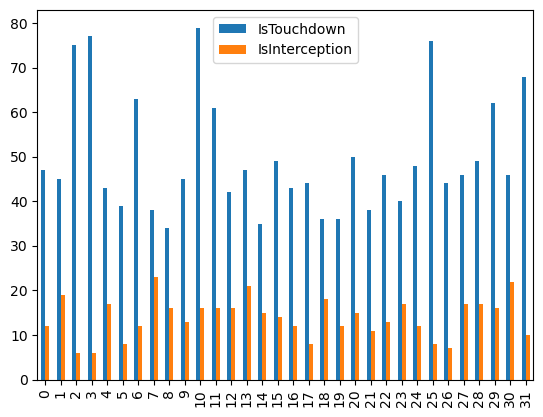

In [13]:
# make a graph to see data and how num of TDs and INTs relate
new.plot(kind='bar')

# Clean Data
Clean data and make it ready for MDP and Q-learning by only keeping necessary columns. Some columns will be deleted, some will be joined, some will be created.

Function to prepare dataset for markov models. Will only leave data with user given team, down, quarter, and field position. Will modify columns as well

In [3]:
# function to reorganize data for markov models so unecessary data is removed
# function will take in the dataset and user inputted data (quarter, team, and desired outcome)
# function will return updated dataset
def markov_reorganize(data_set, quarter, down, team, field_side):
    # ensure data is sorted in sequential order
    # sort data first by game id, then by quarter, followed by time remaining
    data_set = data_set.sort_values(by=['GameId', 'Quarter', 'Minute', 'Second'], ascending=[True, True, False, False])
    
    # set an other quarter variable that may need to be used if there aren't enough specific play results within one quarter
    if ((quarter == 1) | (quarter == 3)):
        other_q = quarter + 1
    else:
        other_q = quarter - 1
        
    # create a data frame with only the necessary data points
    updated_data = pd.DataFrame(data_set[(data_set['OffenseTeam'] == team) & (data_set['Down'] == down) & (data_set['YardLineDirection'] == field_side) & ((data_set['Quarter'] == quarter) | (data_set['Quarter'] == other_q))]
                                [['OffenseTeam', 'Quarter', 'Down', 'ToGo', 'Yards', 'YardLineDirection', 'PlayType', 'Formation', 'IsTouchdown', 
                                  'IsInterception', 'IsFumble', 'IsSack']])
    
    # clean columns so rows with uneccessary data are gone

    # get rid of 'NaN' values
    updated_data = updated_data.dropna(subset=['PlayType'])

    # change quarter 5 to OT for overtime
    updated_data['Quarter'] = np.where(updated_data['Quarter'] == 5, 'OT', updated_data['Quarter'])
    
    # only need play data for when play was a pass, run, or sramble (all other play types were either equivalent to no play or special teams play)
    #updated_data = updated_data[(updated_data['PlayType'] == 'PASS') | (updated_data['PlayType'] == 'RUSH') | (updated_data['PlayType'] == 'SCRAMBLE') | (updated_data['PlayType'] == 'FIELD GOAL')]
    updated_data = updated_data[(updated_data['PlayType'] == 'PASS') | (updated_data['PlayType'] == 'RUSH')]
    
    # combine 'IsInterception' and 'IsFumble' into one turnover column; afterwards get rid of two original columns
    updated_data['IsTurnover'] = updated_data['IsInterception'] + updated_data['IsFumble']
    updated_data['IsTurnover'] = np.where(updated_data['IsTurnover'] == 0, False, True)
    updated_data = updated_data.drop(columns=['IsInterception', 'IsFumble'])
    
    # create new column for negative plays (sack or loss of yards); get rid of sack column
    updated_data['IsNegativePlay'] = np.where((updated_data['IsSack'] == 1) | (updated_data['Yards'] < 0), True, False)
    updated_data = updated_data.drop(columns='IsSack')

    # create new column for next down based on current down, yards to go, and yards gained
    updated_data['NextDown'] = np.where((updated_data['Yards'] < updated_data['ToGo']), updated_data['Down'] + 1, 1)
    updated_data['NextDown'] = np.where(updated_data['IsTouchdown'] == 1, 'TD', updated_data['NextDown'])
    updated_data['NextDown'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] >= updated_data['ToGo']), 1, updated_data['NextDown'])
    updated_data['NextDown'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] < updated_data['ToGo']), 'TO', updated_data['NextDown'])
    updated_data['IsTurnover'] = np.where(updated_data['NextDown'] == 'TO', True, updated_data['IsTurnover'])
    #updated_data['NextDown'] = np.where(updated_data['IsTurnover'] == True, 'TO', updated_data['NextDown'])

    #updated_data['NextDown'] = np.where((updated_data['NextDown'] == 5
     # adjust the turnover and next down stats for when offense gos for it on fourth down
    #updated_data['IsTurnover'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] < updated_data['ToGo']), True, updated_data['IsTurnover'])
    #updated_data['NextDown'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] < updated_data['ToGo']), "TO", 1)

    # adjust the turnover and next down stats for when offense gos for it on fourth down
    #updated_data['IsTurnover'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] < updated_data['ToGo']), True, updated_data['IsTurnover'])
    #updated_data['NextDown'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] < updated_data['ToGo']), "TO", 1)
    
    updated_data['YardLine'] = updated_data['YardLineDirection']
    #updated_data = updated_data.drop(columns=['Yards'])
    
    updated_data['YardsToGo'] = 0
    updated_data['YardsToGo'] = np.where(updated_data['ToGo'] <= 5, 'Short', updated_data['YardsToGo'])
    updated_data['YardsToGo'] = np.where(updated_data['ToGo'] <= 10, 'Medium', updated_data['YardsToGo'])
    updated_data['YardsToGo'] = np.where(updated_data['ToGo'] > 10, 'Long', updated_data['YardsToGo'])

    '''
    if to_go <= 5:
        length = 'Short'
    elif to_go <= 10:
        length = 'Medium'
    else:
        length = 'Long'

    print("length is", length)
    print(updated_data['YardsToGo'])
    
    updated_data = updated_data[updated_data['YardsToGo'] == length]
    '''

    # replace 'IsTouchdown' values with boolean values
    updated_data['IsTouchdown'] = np.where(updated_data['IsTouchdown'] == 1, True, False)

    # new column for field goals
    #updated_data['IsFieldGoal'] = np.where(updated_data['PlayType'] == 'FIELD GOAL', True, False)

    # rearrange columns (makes it easier to read for debugging)
    updated_data = updated_data[['OffenseTeam', 'Quarter', 'Down', 'YardsToGo', 'NextDown', 'YardLine', 'PlayType', 'Formation', 'IsTouchdown', 'IsTurnover', 'IsNegativePlay']]
    #updated_data = updated_data.sort_values(by='Quarter', ascending=True)
    
    return updated_data


Function to prepare dataset for q-learning. Will only filter by team, but will modify columns

In [4]:
# function to reorganize data for q-learning so unnecessary data is removed
# function will take in the dataset and user inputted team
# function will return updated dataset
def q_reorganize(data_set, team):
    # ensure data is sorted in sequential order
    # sort data first by game id, then by quarter, followed by time remaining
    data_set = data_set.sort_values(by=['GameId', 'Quarter', 'Minute', 'Second'], ascending=[True, True, False, False])
    
    # create a data frame with inputted team's data
    updated_data = pd.DataFrame(data_set[(data_set['OffenseTeam'] == team)]
                                [['OffenseTeam', 'Quarter', 'Down', 'ToGo', 'Yards', 'YardLineDirection', 'PlayType', 'Formation', 'IsTouchdown', 
                                  'IsInterception', 'IsFumble', 'IsSack']])
    
    # clean columns so rows with uneccessary data are gone

    # get rid of 'NaN' values
    updated_data = updated_data.dropna(subset=['PlayType'])

    # change quarter 5 to OT for overtime
    updated_data['Quarter'] = np.where(updated_data['Quarter'] == 5, 'OT', updated_data['Quarter'])
    
    # only need play data for when play was a pass, run, or sramble (all other play types were either equivalent to no play or special teams play)
    #updated_data = updated_data[(updated_data['PlayType'] == 'PASS') | (updated_data['PlayType'] == 'RUSH') | (updated_data['PlayType'] == 'SCRAMBLE') | (updated_data['PlayType'] == 'FIELD GOAL')]
    updated_data = updated_data[(updated_data['PlayType'] == 'PASS') | (updated_data['PlayType'] == 'RUSH')]
    
    # combine 'IsInterception' and 'IsFumble' into one turnover column; afterwards get rid of two original columns
    updated_data['IsTurnover'] = updated_data['IsInterception'] + updated_data['IsFumble']
    updated_data['IsTurnover'] = np.where(updated_data['IsTurnover'] == 0, False, True)
    updated_data = updated_data.drop(columns=['IsInterception', 'IsFumble'])
    
    # create new column for negative plays (sack or loss of yards); get rid of sack column
    updated_data['IsNegativePlay'] = np.where((updated_data['IsSack'] == 1) | (updated_data['Yards'] < 0), True, False)
    updated_data = updated_data.drop(columns='IsSack')

    # create new column for next down based on current down, yards to go, and yards gained
    updated_data['NextDown'] = np.where((updated_data['Yards'] < updated_data['ToGo']), updated_data['Down'] + 1, 1)
    updated_data['NextDown'] = np.where(updated_data['IsTouchdown'] == 1, 'TD', updated_data['NextDown'])
    updated_data['NextDown'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] >= updated_data['ToGo']), 1, updated_data['NextDown'])
    updated_data['NextDown'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] < updated_data['ToGo']), 'TO', updated_data['NextDown'])
    updated_data['IsTurnover'] = np.where(updated_data['NextDown'] == 'TO', True, updated_data['IsTurnover'])
    #updated_data['NextDown'] = np.where(updated_data['IsTurnover'] == True, 'TO', updated_data['NextDown'])

    #updated_data['NextDown'] = np.where((updated_data['NextDown'] == 5
     # adjust the turnover and next down stats for when offense gos for it on fourth down
    #updated_data['IsTurnover'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] < updated_data['ToGo']), True, updated_data['IsTurnover'])
    #updated_data['NextDown'] = np.where((updated_data['NextDown'] == 5) & (updated_data['Yards'] < updated_data['ToGo']), "TO", 1)
    
    updated_data['YardLine'] = updated_data['YardLineDirection']
    #updated_data = updated_data.drop(columns=['Yards'])
    
    
    updated_data['YardsToGo'] = 0
    updated_data['YardsToGo'] = np.where(updated_data['ToGo'] <= 5, 'Short', updated_data['YardsToGo'])
    updated_data['YardsToGo'] = np.where(updated_data['ToGo'] <= 10, 'Medium', updated_data['YardsToGo'])
    updated_data['YardsToGo'] = np.where(updated_data['ToGo'] > 10, 'Long', updated_data['YardsToGo'])

    '''
    if to_go <= 5:
        length = 'Short'
    elif to_go <= 10:
        length = 'Medium'
    else:
        length = 'Long'

    print("length is", length)
    print(updated_data['YardsToGo'])
    
    updated_data = updated_data[updated_data['YardsToGo'] == length]
    '''

    # replace 'IsTouchdown' values with boolean values
    updated_data['IsTouchdown'] = np.where(updated_data['IsTouchdown'] == 1, True, False)

    # new column for field goals
    #updated_data['IsFieldGoal'] = np.where(updated_data['PlayType'] == 'FIELD GOAL', True, False)

    # rearrange columns (makes it easier to read for debugging)
    updated_data = updated_data[['OffenseTeam', 'Quarter', 'Down', 'YardsToGo', 'NextDown', 'YardLine', 'PlayType', 'Formation', 'IsTouchdown', 'IsTurnover', 'IsNegativePlay']]
    
    return updated_data


#  Implementing Markov Models
Implenting Markov Models, both the Markov Decision Process (which is mentioned in my proposal and crucial to the final result of my project) and the Hidden Markov Model as Professor Alam stated in his Mid-Project Submission requirements. I had to do Markov Models as my data is of the sequential type. I determined it was of this type as the data includes a row of various data points, but these rows are given in a play-by-play sequence and if this sequence were to become completely random, the data would lose most of its meaning. Additionally, each entry (play) is dependent on the previous play as some plays wouldn't make sense for certain previous plays. For instance, if a team runs a play on first down and fail to pick up a first, the next play cannot be any play other than on second down. Each down and play result is essentially a state and the play type and formation is an action.

Implementing the Markov Decision Process to decide most optimal play for team in given situation

In [6]:
# class to implement Markov Decision Process
# when class object is declared, class will take the processed data and quarter and use them to implement a MDP
class MDP:
    # "constructor" to save necessary values into class and begin process
    def __init__(self, reward, data, quarter):
        # save dataset to class
        self.data = data
        self.quarter = str(quarter)

        # reward dictionary to make it easier to access reward by read next down
        self.rewards = {"Turnover": reward[0], "NegPlay": reward[1], "NextDown": reward[2], "FirstDown": reward[3], "Touchdown": reward[4]}
        # set reward amounts (rewards for each action will depend on the new state)
        self.Touchdown_reward = 10
        self.FirstDown_reward = 5
        self.NextDown_reward = 2.5
        #self.FieldGoal_reward = 5
        self.NegativePlay_reward = -5
        self.Turnover_reward = -10

        self.calculate()

    # function to calculate frequency and probabilities of each state (score, turnover, down) occurring given each action (play type and formation)
    # the function takes no parameters and returns none but will call the decision() function
    def calculate(self):
        temp = pd.DataFrame(self.data[(self.data['PlayType'] == 'RUSH')]).sort_values(by='Quarter', ascending=True)
        formations = temp['Formation'].unique()
        rush_df = pd.DataFrame({'FirstDown':0, 'P(FirstDown)':0, 'NextDown':0, 'P(NextDown)':0, 'Touchdown':0, 'P(Touchdown)':0, 'Turnover':0, 'P(Turnover)':0, 'NegativePlay':0, 'P(NegativePlay)':0, 'TotalPlays':0}, index=formations)
        q = str(self.quarter)
        FD_next = ND_next = TD_next = TO_next = NEG_next = 0
        for each in formations:
            for row in temp.itertuples():
                if (row.Formation == each):
                    if (row.NextDown == '1'):
                        rush_df.loc[each, 'FirstDown'] = rush_df.loc[each, 'FirstDown'] + 1
                    if ((row.NextDown != '1') & (row.NextDown != 'TD') & (row.NextDown != 'TO')):
                        rush_df.loc[each, 'NextDown'] = rush_df.loc[each, 'NextDown'] + 1
                    if (row.IsTouchdown == True):
                        rush_df.loc[each, 'Touchdown'] = rush_df.loc[each, 'Touchdown'] + 1
                    if (row.IsTurnover == True):
                        rush_df.loc[each, 'Turnover'] = rush_df.loc[each, 'Turnover'] + 1
                    if (row.IsNegativePlay == True):
                        rush_df.loc[each, 'NegativePlay'] = rush_df.loc[each, 'NegativePlay'] + 1
                    rush_df.loc[each, 'TotalPlays'] = rush_df.loc[each, 'TotalPlays'] + 1

        for each in formations:
            rush_df.loc[each, 'P_FirstDown'] = rush_df.loc[each, 'FirstDown'] / rush_df.loc[each, 'TotalPlays']
            rush_df.loc[each, 'P_NextDown'] = rush_df.loc[each, 'NextDown'] / rush_df.loc[each, 'TotalPlays']
            rush_df.loc[each, 'P_Touchdown'] = rush_df.loc[each, 'Touchdown'] / rush_df.loc[each, 'TotalPlays']
            rush_df.loc[each, 'P_Turnover'] = rush_df.loc[each, 'Turnover'] / rush_df.loc[each, 'TotalPlays']
            rush_df.loc[each, 'P_NegativePlay'] = rush_df.loc[each, 'NegativePlay'] / rush_df.loc[each, 'TotalPlays']
        #print("\nRUSHING:\n", rush_df)

        temp = pd.DataFrame(self.data[(self.data['PlayType'] == 'PASS')]).sort_values(by='Quarter', ascending=True)
        formations = temp['Formation'].unique()
        pass_df = pd.DataFrame({'FirstDown':0, 'NextDown':0, 'Touchdown':0, 'Turnover':0, 'NegativePlay':0, 'TotalPlays':0}, index=formations)
        q = str(self.quarter)
        FD_next = ND_next = TD_next = TO_next = NEG_next = 0
        for each in formations:
            for row in temp.itertuples():
                if (row.Formation == each):
                    if (row.NextDown == '1'):
                        pass_df.loc[each, 'FirstDown'] = pass_df.loc[each, 'FirstDown'] + 1
                    if ((row.NextDown != '1') & (row.NextDown != 'TD') & (row.NextDown != 'TO')):
                        pass_df.loc[each, 'NextDown'] = pass_df.loc[each, 'NextDown'] + 1
                    if (row.IsTouchdown == True):
                        pass_df.loc[each, 'Touchdown'] = pass_df.loc[each, 'Touchdown'] + 1
                    if (row.IsTurnover == True):
                        pass_df.loc[each, 'Turnover'] = pass_df.loc[each, 'Turnover'] + 1
                    if (row.IsNegativePlay == True):
                        pass_df.loc[each, 'NegativePlay'] = pass_df.loc[each, 'NegativePlay'] + 1
                    pass_df.loc[each, 'TotalPlays'] = pass_df.loc[each, 'TotalPlays'] + 1

        for each in formations:
            pass_df.loc[each, 'P_FirstDown'] = pass_df.loc[each, 'FirstDown'] / pass_df.loc[each, 'TotalPlays']
            pass_df.loc[each, 'P_NextDown'] = pass_df.loc[each, 'NextDown'] / pass_df.loc[each, 'TotalPlays']
            pass_df.loc[each, 'P_Touchdown'] = pass_df.loc[each, 'Touchdown'] / pass_df.loc[each, 'TotalPlays']
            pass_df.loc[each, 'P_Turnover'] = pass_df.loc[each, 'Turnover'] / pass_df.loc[each, 'TotalPlays']
            pass_df.loc[each, 'P_NegativePlay'] = pass_df.loc[each, 'NegativePlay'] / pass_df.loc[each, 'TotalPlays']
        #print("\nPASSING:\n", pass_df)

        # save data frames within class
        self.pass_plays = pass_df
        self.rush_plays = rush_df

        # call class' decision function
        #self.decision()

    # function to make the decision for which play is most optimal in the given situation
    # function takes no arguments but utilizes class' saved variables along with the Bellman equation to determine the play
    # this function is essentially a version of the Bellman equation and outputs a list that contains the most optimal play,
    # the reward value, and the play outcome (the transition state)
    def decision(self):
        discount = 0.4 # as project is supposed to be a simplified play decider meant to be used at amateur level, discount factors will be set to 1 for now
        V_0 = 0 # previous state doesn't matter as project aims to decide best single play in a current situation and not a sequence of plays

        # make an empty list to store the rewards of each possible action going to each state
        # easy way to keep track of results and use them in Bellman equation
        values = []

        for row in self.rush_plays.itertuples():
            val = row.P_FirstDown * (self.rewards['FirstDown'] + (discount * V_0))
            values.append(["Rush to first down", row.Index, val])
            val = row.P_NextDown * (self.rewards['NextDown'] + (discount * V_0))
            values.append(["Rush to next down", row.Index, val])
            val = row.P_Touchdown * (self.rewards['Touchdown'] + (discount * V_0))
            values.append(["Rush to touchdown", row.Index, val])
            val = row.P_Turnover * (self.rewards['Turnover'] + (discount * V_0))
            values.append(["Rush to turnover", row.Index, val])
            val = row.P_NegativePlay * (self.rewards['NegPlay'] + (discount * V_0))
            values.append(["Rush to negative play", row.Index, val])

        for row in self.pass_plays.itertuples():
            val = row.P_FirstDown * (self.rewards['FirstDown'] + (discount * V_0))
            values.append(["Pass to first down", row.Index, val])
            val = row.P_NextDown * (self.rewards['NextDown'] + (discount * V_0))
            values.append(["Pass to next down", row.Index, val])
            val = row.P_Touchdown * (self.rewards['Touchdown'] + (discount * V_0))
            values.append(["Pass to touchdown", row.Index, val])
            val = row.P_Turnover * (self.rewards['Turnover'] + (discount * V_0))
            values.append(["Pass to turnover", row.Index, val])
            val = row.P_NegativePlay * (self.rewards['NegPlay'] + (discount * V_0))
            values.append(["Pass to negative play", row.Index, val])


        max_val = values[0][2]
        max_list = values[0]
        for i in range(1, len(values)):
            if (values[i][2] > max_val):
                max_val = values[i][2]
                max_list = values[i]

        #print("Most optimal play is", max_list)
        #print("Most optimal play is to", max_list[0], "in", max_list[1], "formation")
        return max_list
    

Implement Hidden Markov Model to generate sequence of play outcomes that can lead to a TD

In [130]:
# class to implement a hidden markov model
# this will be similar to the MDP class as the observed states will be the play results (first down, TD, etc)
# and the hidden states will be the play type, pass or fail
class HMM:
    # "constructor" to save necessary values into class and begin process
    def __init__(self, data, quarter):
        # save dataset to class
        self.data = data
        self.quarter = str(quarter)
        
        self.calculate()

    def calculate(self):
        plays = ['RUSH', 'PASS']
        
        # make data frame for probabilities related to hidden states (rush and pass)
        hidden = pd.DataFrame({'Pass-Pass':0.0, 'Pass-Rush':0.0, 'Rush-Pass':0.0, 'Rush-Rush':0.0, 'TotalPlays':0.0}, index=plays)

        
        # make a data frame for probabilities related to observed states (play results: first down, next down, TD, turnover, negative play)
        observed = pd.DataFrame({'FirstDown':0.0, 'NextDown':0.0, 'Touchdown':0.0, 'Turnover':0.0, 'NegativePlay':0.0, 'TotalPlays':0.0}, index=plays)
        
        # variable to hold previous play type
        prev = None
        # helper variable
        i = 0
        for row in self.data.itertuples():
            if (i == 0):
                prev = row.PlayType
                i = i + 1
            else:
                if (row.PlayType == 'PASS'):
                    if (prev == 'PASS'):
                        hidden.loc['PASS', 'Pass-Pass'] = hidden.loc['PASS', 'Pass-Pass'] + 1
                    elif (prev == 'RUSH'):
                        hidden.loc['PASS', 'Rush-Pass'] = hidden.loc['PASS', 'Rush-Pass'] + 1
                    hidden.loc['PASS', 'TotalPlays'] = hidden.loc['PASS', 'TotalPlays'] + 1
                elif (row.PlayType == 'RUSH'):
                    if (prev == 'PASS'):
                        hidden.loc['RUSH', 'Pass-Rush'] = hidden.loc['RUSH', 'Pass-Rush'] + 1
                    elif (prev == 'RUSH'):
                        hidden.loc['RUSH', 'Rush-Rush'] = hidden.loc['RUSH', 'Rush-Rush'] + 1
                    hidden.loc['RUSH', 'TotalPlays'] = hidden.loc['RUSH', 'TotalPlays'] + 1
                prev = row.PlayType
                
             
            if ((row.PlayType == 'PASS') | (row.PlayType == 'RUSH')):
                if (row.NextDown == '1'):
                    observed.loc[row.PlayType, 'FirstDown'] = observed.loc[row.PlayType, 'FirstDown'] + 1
                elif ((row.NextDown != '1') & (row.NextDown != 'TD') & (row.NextDown != 'TO')):
                    observed.loc[row.PlayType, 'NextDown'] = observed.loc[row.PlayType, 'NextDown'] + 1
                elif (row.IsTouchdown == True):
                    observed.loc[row.PlayType, 'Touchdown'] = observed.loc[row.PlayType, 'Touchdown'] + 1
                elif (row.IsTurnover == True):
                    observed.loc[row.PlayType, 'Turnover'] = observed.loc[row.PlayType, 'Turnover'] + 1
                elif (row.IsNegativePlay == True):
                    observed.loc[row.PlayType, 'NegativePlay'] = observed.loc[row.PlayType, 'NegativePlay'] + 1
                observed.loc[row.PlayType, 'TotalPlays'] = observed.loc[row.PlayType, 'TotalPlays'] + 1   

        # turn frequencies into probailities
        for row in hidden.itertuples():
            each = row.Index
            hidden.loc[each, 'Pass-Pass'] = hidden.loc[each, 'Pass-Pass'] / hidden.loc[each, 'TotalPlays']
            hidden.loc[each, 'Pass-Rush'] = hidden.loc[each, 'Pass-Rush'] / hidden.loc[each, 'TotalPlays']
            hidden.loc[each, 'Rush-Pass'] = hidden.loc[each, 'Rush-Pass'] / hidden.loc[each, 'TotalPlays']
            hidden.loc[each, 'Rush-Rush'] = hidden.loc[each, 'Rush-Rush'] / hidden.loc[each, 'TotalPlays']
        
        for row in observed.itertuples():
            each = row.Index
            observed.loc[each, 'FirstDown'] = observed.loc[each, 'FirstDown'] / observed.loc[each, 'TotalPlays']
            observed.loc[each, 'NextDown'] = observed.loc[each, 'NextDown'] / observed.loc[each, 'TotalPlays']
            observed.loc[each, 'Touchdown'] = observed.loc[each, 'Touchdown'] / observed.loc[each, 'TotalPlays']
            observed.loc[each, 'Turnover'] = observed.loc[each, 'Turnover'] / observed.loc[each, 'TotalPlays']
            observed.loc[each, 'NegativePlay'] = observed.loc[each, 'NegativePlay'] / observed.loc[each, 'TotalPlays']


        # save hidden and observed data frames into class
        self.hidden_states = plays
        self.p_hidden = hidden.drop('TotalPlays', axis=1)
        self.observed_states = ['FirstDown', 'NextDown', 'Touchdown', 'Turnover', 'NegativePlay']
        self.p_observed = observed.drop('TotalPlays', axis=1)

        self.generate_drive()

    # function to generate possible play outcome sequence starting from inputted field side to end in a TD
    # function is based off the observeGenerating() function in hmm.ipynb shared by Professor Alam
    def generate_drive(self):
        # empty list to store the drive plays
        drive = []

        # variable to prevent drive from having 4+ downs before first down or touchdown
        # should always be in range of 1-4; can never be > 4
        current_down = 1
        
        state = np.random.choice(self.hidden_states, 1, p = [0.5, 0.5])[0]

        observe = np.random.choice(self.observed_states, 1, p = self.p_observed.loc[state].tolist())[0]
        if (observe == 'FirstDown'):
            current_down = 1
        elif ((observe == 'NextDown') & (current_down < 4)):
            current_down = current_down + 1
        drive.append(observe)

        for i in range(15):
            # make list of probability to go to next hidden state based on current state
            # but normalize first
            if (state == 'RUSH'):
                norm = self.p_hidden.loc[state, 'Rush-Rush'] + self.p_hidden.loc[state, 'Rush-Pass']
                hidden_prob = [self.p_hidden.loc[state, 'Rush-Rush'] / norm, self.p_hidden.loc[state, 'Rush-Pass'] / norm]
            else:
                norm = self.p_hidden.loc[state, 'Pass-Rush'] + self.p_hidden.loc[state, 'Pass-Pass']
                hidden_prob = [self.p_hidden.loc[state, 'Pass-Rush'] / norm, self.p_hidden.loc[state, 'Pass-Pass'] / norm]
                
            state = np.random.choice(self.hidden_states, 1, p = hidden_prob)[0]
            observe = np.random.choice(self.observed_states, 1, p = self.p_observed.loc[state].tolist())[0]
            
            while ((observe == 'NextDown') & (current_down == 4)):
                observe = np.random.choice(self.observed_states, 1, p = self.p_observed.loc[state].tolist())[0]
            if ((observe == 'NextDown') & (current_down < 4)):
                current_down = current_down + 1
            elif (observe == 'FirstDown'):
                current_down = 1
            
            drive.append(observe)
            
            if observe == 'Touchdown':
                break


        print(" ".join(drive))

        # if after all 15 iteration, no TD scored
        if (len(drive) == 15):
            if (drive[14] != 'Touchdown'):
                print("Touchdown unlikely in the sequence")

# Implement Q-Learning
Implemented q-learning to determine most optimal play in given situation. Class will analyze dataset and update q-values corresponding to the current state. Once all q-values are updated, it'll choose the max q-value in the user given state.

In [10]:
class Q:
    # class variables that are already determined and needed by all or most functions    
    # down dictionary to easily translate between read down and down needed for calculations
    downs = {"1": "FirstDown", "2": "SecondDown", "3": "ThirdDown", "4": "FourthDown", "TD": "Touchdown", "TO": "Turnover"}
    # list of possible states (since q-learning requires all data from team to be read, there will be more states than Markov Model
    states = ['FirstDown', 'SecondDown', 'ThirdDown', 'FourthDown', 'Touchdown', 'Turnover', 'NegativePlay']

    # "constructor" of class
    def __init__(self, reward, data, quarter, down, field_side):
        self.data = data
        self.quarter = int(quarter)
        self.current_down = down
        self.territory = field_side

        # reward dictionary to make it easier to access reward by read next down
        self.rewards = {"Turnover": reward[0], "NegPlay": reward[1], "SecondDown": reward[2], "ThirdDown": reward[2], "FourthDown": reward[2], "FirstDown": reward[3], "Touchdown": reward[4]}
        
        self.make_Q_Table()

    # function to initialize q-table
    # takes no parameters and will use data to make empty q-table where
    # columns are all the actions taken (will not include all possible actions
    # as not every team has taken each action in given situation)
    # will return no value but will call next function to fill table
    def make_Q_Table(self):
        # find all formations (actions) for when team does a pass in given situation
        pass_formations = self.data[self.data['PlayType'] == 'PASS'][['PlayType', 'Formation']]
        pass_formations = pass_formations['Formation'].unique().tolist()
        for i in range(len(pass_formations)):
            pass_formations[i] = pass_formations[i] + " PASS"

        # find all formations (actions) for when team does a rush in given situation
        rush_formations = self.data[self.data['PlayType'] == 'RUSH'][['PlayType', 'Formation']]
        rush_formations = rush_formations['Formation'].unique().tolist()
        for i in range(len(rush_formations)):
            rush_formations[i] = rush_formations[i] + " RUSH"

        # make list of all possible actions (run and pass)
        actions = pass_formations + rush_formations

        # make data frame with each action as a column, each state as an index, and fill it with all 0s (by default)
        # a data frame will be made for each quarter and each field side (to ensure all possible states are included)
        # for example, 1st down in the 2nd quarter in opponent territory is not the same as 2nd down in overtime in your own territory
        # this code snippet could be sorter, but was written out to show full details of what's happening
        q1_own = pd.DataFrame(0.0, index=self.states, columns=actions)
        q1_opp = pd.DataFrame(0.0, index=self.states, columns=actions)
        q2_own = pd.DataFrame(0.0, index=self.states, columns=actions)
        q2_opp = pd.DataFrame(0.0, index=self.states, columns=actions)
        q3_own = pd.DataFrame(0.0, index=self.states, columns=actions)
        q3_opp = pd.DataFrame(0.0, index=self.states, columns=actions)
        q4_own = pd.DataFrame(0.0, index=self.states, columns=actions)
        q4_opp = pd.DataFrame(0.0, index=self.states, columns=actions)
        OT_own = pd.DataFrame(0.0, index=self.states, columns=actions)
        OT_opp = pd.DataFrame(0.0, index=self.states, columns=actions)

        q1 = [q1_own, q1_opp]
        q2 = [q2_own, q2_opp]
        q3 = [q3_own, q3_opp]
        q4 = [q4_own, q4_opp]
        ot = [OT_own, OT_opp]
        self.q_table = [q1, q2, q3, q4, ot]
        
        self.fill_Q_Table()

    # function to read through data and fill q-table by using q-learning formula
    # q-values for states "Touchdown", "Turnover", and "NegativePlay" will always stay
    # at 0 as there states are terminating plays meaning that no play can occur at these
    # states, plays can only transition to them. They're still in the table to include all details of what's happening
    def fill_Q_Table(self):
        # set up constant for Q(s, a) equation
        discount = 0.4 # as project is supposed to be a simplified play decider meant to be used at amateur level, discount factors will be set to 1 for now
        learning_rate = 0.3 # this value makes sure agent learns from new experience, but still values older experience as there should be more older plays versus just one new play

        # iterate through data and fill q-table
        # will evaluate the following equation for each play:
        #      Q(s, a) <- Q(s, a) + (learning_rate)[reward + (discount)(max(Q(s', a')) - Q(s, a)]
        for each in self.data.itertuples():
            each_quarter = 5 if (each.Quarter == "OT") else int(each.Quarter)
                
            each_down = self.downs[str(each.Down)]
            
            if (each.NextDown == "1"):
                each_next_down = "FirstDown"
            elif (each.NextDown == "2"):
                each_next_down = "SecondDown"
            elif (each.NextDown == "3"):
                each_next_down = "ThirdDown"
            elif (each.NextDown == "4"):
                each_next_down = "FourthDown"
            elif (each.NextDown == "TD"):
                each_next_down = "Touchdown"
            else:
                each_next_down = "Turnover"
            
            territory = 0 if (each.YardLine == 'OWN') else 1
            
            each_formation = each.Formation
            each_play_type = each.PlayType

            action = each_formation + " " + each_play_type
            current_q = self.q_table[each_quarter - 1][territory].loc[each_down, action]
            
            if each.IsNegativePlay == True:
                reward = self.rewards["NegPlay"]
                each_next_down = "NegativePlay"
            else:
                reward = self.rewards[each_next_down]

            max_next_q = self.q_table[each_quarter - 1][territory].loc[each_next_down].max()
            q_value = current_q + (learning_rate) * (reward + ((discount) * (max_next_q)) - current_q)
            self.q_table[each_quarter - 1][territory].loc[each_down, action] = q_value

        '''for i in range(5):
            for j in range(2):
                print("Q", i + 1)
                print("OWN" if j == 0 else "OPP")
                print(self.q_table[i][j])
                print("\n\n\n")'''
        
    # function to determine most optimal play. Will go to sub-table corresponding to the user's
    # given quarter and field position. Once in this sub-table, it'll look for the row corresponding
    # to the user's inputted down. It'll locate the max q-value in this row and output the corresponding formation
    def make_decision(self):
        territory = 0 if (self.territory == "OWN") else 1
        # find max q-value in table corresponding to given situation
        max_q = self.q_table[self.quarter - 1][territory].loc[self.downs[str(self.current_down)]].max() # get the max value
        max_action = self.q_table[self.quarter - 1][territory].loc[self.downs[str(self.current_down)]].idxmax() # get action of max value

        return [max_action, max_q]

        #return f"Most optimal play is a {max_action} due to a q-value of {max_q}"
        

# Main program

In [131]:
# main program to ask user for information and begin play deciding model
def main():
    error = 0
    
    # read in data
    data = pd.read_csv('pbp-2024.csv')

    # make a list of all teams in data set
    teams = data['OffenseTeam'].unique()

    # list of downs
    downs = [1, 2, 3, 4]
    
    # ask user for required inputs
    print("Welcome to the football assistant coach agent!")
    print("This agent will help you decide the most optimal play to run in a given situation, assuming you've decided to run an offensive play")
    print("After deciding two possible plays, using two separate implementations, it'll provide a sequence of play results to end in a touchdown")
    print("When prompted please enter the current quarter, down, your team, and your field position")
    print("\tPlease note:")
    print("\t\t1. Valid quarters are 1, 2, 3, 4, and 5 (for overtime); while valid downs are 1-4")
    print("\t\t2. Your team should be abbreviated as one of the following:\n", teams)
    print("\t\t3. Field position should be either 'OPP' for opponent side or 'OWN' for own side, midfield can be either")
    print("\t\t4. Please separate each value with a space")

    # save user input
    quarter, down, team, field_side = input("Please Enter Your Data: ").split()

    # ensure user has inputted valid quarter
    if ((quarter != '1') & (quarter != '2') & (quarter != '3') & (quarter != '4') & (quarter != '5')):
        print("\nERROR: Invalid quarter\n")
        exit()

    if int(down) not in downs:
        print("Only 1, 2, 3, or 4 are valid downs")
        quit()
        
    if team.upper() not in teams:
        print("\nERROR: Invalid team\n")
        exit()

    
    # clean data; one filtered data for markov models, one for q-learning
    markov_data = markov_reorganize(data, int(quarter), int(down), team.upper(), field_side.upper())
    q_data = q_reorganize(data, team.upper())
 
    # list of rewards in [Turnover, Negative Play, Next Down, First Down, Touchdown]
    rewards1 = [-10, -5, 2.5, 5, 10]
    rewards2 = [-7, 0, 0, 3.5, 7] # values next down and negative plays as non-rewarding
    rewards3 = [-10, -5, 0, 10, 10] # values first downs as much as touchdowns
    rewards4 = [-10, -5, 0, 10, 5] # values first downs more than touchdowns

    
    test = Q(rewards1, q_data, quarter, down, field_side.upper())
    print("According to Q-learning:", test.make_decision())
    test = MDP(rewards1, markov_data, quarter)
    print("According to MDP:", test.decision())

    print("\nPotential TD drives")
    for i in range(10):
        print("Drive #", i + 1)
        test = HMM(markov_data, quarter)
        print("\n")
    
if __name__ == "__main__":
	main()

Welcome to the football assistant coach agent!
This agent will help you decide the most optimal play to run in a given situation, assuming you've decided to run an offensive play
After deciding two possible plays, using two separate implementations, it'll provide a sequence of play results to end in a touchdown
When prompted please enter the current quarter, down, your team, and your field position
	Please note:
		1. Valid quarters are 1, 2, 3, 4, and 5 (for overtime); while valid downs are 1-4
		2. Your team should be abbreviated as one of the following:
 ['GB' 'MIN' 'PIT' 'CIN' 'TB' 'CAR' 'JAX' 'TEN' 'ATL' 'WAS' 'IND' 'NYG'
 'BUF' 'NYJ' 'NO' 'LV' 'LA' 'SEA' 'CHI' 'ARI' 'CLE' 'HOU' 'BAL' 'KC' 'DAL'
 'DEN' 'NE' 'LAC' 'MIA' 'SF' 'PHI' 'DET']
		3. Field position should be either 'OPP' for opponent side or 'OWN' for own side, midfield can be either
		4. Please separate each value with a space


Please Enter Your Data:  1 1 ne own


According to Q-learning: ['UNDER CENTER PASS', 5.366031867710074]
According to MDP: ['Rush to next down', 'NO HUDDLE', 2.5]

Potential TD drives
Drive # 1
NextDown NextDown FirstDown NextDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown FirstDown


Drive # 2
NextDown FirstDown NextDown NextDown NextDown FirstDown FirstDown NextDown NextDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown


Drive # 3
NextDown NextDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown NextDown


Drive # 4
NextDown NextDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown NextDown NextDown FirstDown


Drive # 5
NextDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown FirstDown FirstDown NextDown NextDown FirstDown FirstDown FirstDown FirstDown


Drive # 6
NextDown NextDown FirstDown FirstDown N

# Implementations' Results

Cells below shows the MDP class working correctly as it successfully outputs the most optimal play in the form of [play type and play result, formation, and Bellman equation result]

In [353]:
rewards = [-10, -5, 2.5, 5, 10]

print("NE on 1st down in 2nd quarter in opponent territory:")
data = pd.read_csv('pbp-2024.csv')
data = markov_reorganize(data, 2, 1, 'NE', 'OPP')
test = MDP(rewards, data, 2)
print(test.decision())

print("\nCIN on 4th down in 3rd quarter in opponent territory:")
data = pd.read_csv('pbp-2024.csv')
data = markov_reorganize(data, 3, 4, 'CIN', 'OPP')
test = MDP(rewards, data, 4)
print(test.decision())

print("\nLAC on 2nd down in 4th quarter in own territory:")
data = pd.read_csv('pbp-2024.csv')
data = markov_reorganize(data, 4, 2, 'LAC', 'OWN')
test = MDP(rewards, data, 2)
print(test.decision())

NE on 1st down in 2nd quarter in opponent territory:
['Pass to touchdown', 'NO HUDDLE SHOTGUN', 5.0]

CIN on 4th down in 3rd quarter in opponent territory:
['Pass to touchdown', 'SHOTGUN', 5.7142857142857135]

LAC on 2nd down in 4th quarter in own territory:
['Rush to next down', 'NO HUDDLE SHOTGUN', 2.5]


Finished debugging hidden markov model to output sequence possible play results (potential drive ideas) that can lead to a touchdown. I also ensured that the function makes sure the plays are either 1st, 2nd, 3rd, 4th downs or TDs. They'll be no downs above 4, so a sequence like first down, next down, next down, next down, next down cannot be possible as it would be 5th down after the last result

In [129]:
data = pd.read_csv('pbp-2024.csv')
print("Potential TD drives for IND in 2nd quarter on 2nd down in opponent territory")
markov_data = markov_reorganize(data, 2, 2, 'IND', 'OPP')
for i in range(5):
    print("Drive #", i + 1)
    test = HMM(markov_data, quarter)

print("------------------------------------------------------------------------------")
print("Potential TD drives for TEN in 4th quarter on 4th down in own territory")
markov_data = markov_reorganize(data, 4, 3, 'TEN', 'OWN')
for i in range(5):
    print("Drive #", i + 1)
    test = HMM(markov_data, quarter)

Potential TD drives for IND in 2nd quarter on 2nd down in opponent territory
Drive # 1
FirstDown NextDown NextDown FirstDown FirstDown FirstDown FirstDown Touchdown
Drive # 2
NextDown NextDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown FirstDown FirstDown FirstDown FirstDown NextDown NextDown NextDown
Drive # 3
NextDown NextDown NextDown FirstDown NextDown FirstDown NextDown NextDown NextDown FirstDown NextDown NextDown Touchdown
Drive # 4
NextDown NextDown FirstDown NextDown Touchdown
Drive # 5
FirstDown NextDown NextDown NextDown FirstDown NextDown NextDown FirstDown FirstDown NextDown NextDown NextDown FirstDown FirstDown FirstDown NextDown
------------------------------------------------------------------------------
Potential TD drives for TEN in 4th quarter on 4th down in own territory
Drive # 1
FirstDown FirstDown NextDown NextDown FirstDown NextDown FirstDown FirstDown FirstDown NextDown NextDown NextDown FirstDown FirstDown NextDown NextDown
Drive # 2
Nex

In the second hidden markov model example, there are some repeats which is good because any football fan would tell you that scoring a TD in the fourth quarter on a drive where you have a 3rd down in your own territory is difficult, especially if you're TEN (the team with the worst record).

Completed and working hidden markov model is now in the last code cell of previous section.

The cell below shows the output of using the q-learning class to choose the most optimal play for the same situations used a couple of cells above

In [12]:
rewards = [-10, -5, 2.5, 5, 10]

print("NE on 1st down in 2nd quarter in opponent territory:")
data = pd.read_csv('pbp-2024.csv')
data = q_reorganize(data, 'NE')
test = Q(rewards, data, 2, 1, 'OPP')
print(test.make_decision())

print("\nCIN on 4th down in 3rd quarter in opponent territory:")
data = pd.read_csv('pbp-2024.csv')
data = q_reorganize(data, 'CIN')
test = Q(rewards, data, 3, 4, 'OPP')
print(test.make_decision())

print("\nLAC on 2nd down in 4th quarter in own territory:")
data = pd.read_csv('pbp-2024.csv')
data = q_reorganize(data, 'LAC')
test = Q(rewards, data, 4, 2, 'OWN')
print(test.make_decision())

NE on 1st down in 2nd quarter in opponent territory:
['SHOTGUN PASS', 5.288378039448009]

CIN on 4th down in 3rd quarter in opponent territory:
['SHOTGUN PASS', 6.8787]

LAC on 2nd down in 4th quarter in own territory:
['SHOTGUN PASS', 6.187213093494188]


Just doing a quick eye test to compare the two results of using the three same situations, the play suggestions slightly vary. While they both suggest a pass out of the shotgun formation, the MDP suggests doing a no huddle shotgun play, while q-learning suggests doing a routine shotgun play. The q-values are also similar to the value calculated by the Bellman equation.

# Compare Q-learning results with different rewards

Lets set up the necessary parameters

In [14]:
# read in data
og_data = pd.read_csv('pbp-2024.csv')
    
# make a list of all teams in data set
teams = og_data['OffenseTeam'].unique().tolist()

# list of downs
downs = [1, 2, 3, 4]

# list of quarters
quarters = [1, 2, 3, 4, 'OT']

# list of field side
fields = ['OWN', 'OPP']

Set up 5 different reward lists. These lists are in the form of reward for [turnover, negative play, next down, first down, touchdown]. 
These rewards vary by valuing different states. Some value touchdowns over other states, some value first downs, etc.

In [46]:
rewards1 = [-10, -5, 2.5, 5, 10] # has positive reward for everything but turnover and negative play
rewards2 = [10, 5, 2.5, -5, -10] # values opposite of rewards1; values negative plays
rewards3 = [-10, -10, 0, 10, 10] # values first downs as much as touchdowns; turnovers same as negative plays
rewards4 = [-10, -5, 0, 10, 5] # values first downs more than touchdowns
rewards5 = [-10, 0, 0, 0, 10] # turnover seen as derewarding, touchdowns is only positive reward

Randomly pick a team, quarter, down, and field side to make random situations and add results to table (data frame)

In [47]:
import random
# make empty data frame
df = pd.DataFrame("N/A", index = [i for i in range(1, 11)], columns = ['Situation', 'reward_1', 'reward_2', 'reward_3', 'reward_4', 'reward_5'])

# make 10 different scenarios for comparisons
for i in range(10):
    # randomly pick variable values
    team_index = random.uniform(0, len(teams))
    downs_index = random.uniform(0, 3)
    quarter_index = random.uniform(0, 4)
    field_index = random.uniform(0, 1)
    team = teams[int(team_index)]
    down = downs[int(downs_index)]
    quarter = quarters[int(quarter_index)]
    field_side = fields[int(field_index)]

    # add situation to table
    df.loc[i + 1, 'Situation'] = f"{team} in quarter {quarter} on down {down} in {field_side} territory"

    # filter data
    data = q_reorganize(og_data, team)

    test = Q(rewards1, data, quarter, down, field_side)
    df.loc[i + 1, 'reward_1'] = test.make_decision()

    test = Q(rewards2, data, quarter, down, field_side)
    df.loc[i + 1, 'reward_2'] = test.make_decision()

    test = Q(rewards3, data, quarter, down, field_side)
    df.loc[i + 1, 'reward_3'] = test.make_decision()

    test = Q(rewards4, data, quarter, down, field_side)
    df.loc[i + 1, 'reward_4'] = test.make_decision()

    test = Q(rewards5, data, quarter, down, field_side)
    df.loc[i + 1, 'reward_5'] = test.make_decision()

In [48]:
df

,Situation,reward_1,reward_2,reward_3,reward_4,reward_5
1,NO in quarter 2 on down 1 in OWN territory,"[UNDER CENTER PASS, 4.819945243414752]","[UNDER CENTER RUSH, 3.843303777243897]","[UNDER CENTER PASS, 6.757651103675725]","[UNDER CENTER PASS, 6.758971242699267]","[NO HUDDLE SHOTGUN PASS, 0.5838564183932944]"
2,MIA in quarter 2 on down 2 in OWN territory,"[SHOTGUN PASS, 5.656920276540106]","[UNDER CENTER PASS, 1.64029371]","[SHOTGUN PASS, 7.169073900207823]","[SHOTGUN PASS, 7.174484325454905]","[SHOTGUN PASS, 0.0]"
3,WAS in quarter 1 on down 2 in OWN territory,"[NO HUDDLE SHOTGUN PASS, 5.616759166270757]","[SHOTGUN RUSH, 0.814674]","[NO HUDDLE SHOTGUN PASS, 6.937397737715954]","[NO HUDDLE SHOTGUN PASS, 6.9498796057334]","[SHOTGUN PASS, 0.0]"
4,CAR in quarter 2 on down 1 in OWN territory,"[SHOTGUN PASS, 6.183331970939159]","[SHOTGUN RUSH, 3.2731467312759377]","[SHOTGUN PASS, 7.445160231444722]","[SHOTGUN PASS, 7.027530589444067]","[SHOTGUN PASS, 1.0274581632]"
5,TEN in quarter 2 on down 3 in OWN territory,"[UNDER CENTER RUSH, 3.6077876207856434]","[SHOTGUN PASS, 1.320382342711847]","[UNDER CENTER RUSH, 6.345739052268721]","[UNDER CENTER RUSH, 6.366915872268721]","[SHOTGUN PASS, 0.0]"
6,NYG in quarter 4 on down 1 in OWN territory,"[NO HUDDLE SHOTGUN PASS, 5.831127956569941]","[UNDER CENTER RUSH, 3.2821096898939937]","[NO HUDDLE SHOTGUN PASS, 8.300227661528362]","[NO HUDDLE SHOTGUN PASS, 8.307833434921271]","[SHOTGUN PASS, 1.5434400000000004]"
7,CAR in quarter 4 on down 1 in OWN territory,"[NO HUDDLE SHOTGUN PASS, 4.407003107418344]","[UNDER CENTER RUSH, 3.598842755647691]","[NO HUDDLE SHOTGUN PASS, 4.143179097910348]","[NO HUDDLE SHOTGUN PASS, 4.154112404837548]","[UNDER CENTER PASS, 0.0]"
8,CLE in quarter 1 on down 2 in OWN territory,"[SHOTGUN PASS, 6.318931743591261]","[UNDER CENTER RUSH, 2.508225794019143]","[SHOTGUN PASS, 6.151879499987265]","[UNDER CENTER PASS, 4.907376779985704]","[SHOTGUN PASS, 3.123004811465071]"
9,BUF in quarter 4 on down 1 in OWN territory,"[SHOTGUN PASS, 4.851043019242049]","[UNDER CENTER RUSH, 3.970606240768259]","[UNDER CENTER PASS, 6.097583432777471]","[UNDER CENTER PASS, 6.113572148199715]","[SHOTGUN PASS, 0.11751708372480002]"
10,TEN in quarter 4 on down 2 in OWN territory,"[NO HUDDLE SHOTGUN PASS, 4.739953493896072]","[SHOTGUN RUSH, 2.1239080092624]","[NO HUDDLE SHOTGUN PASS, 4.458601629149246]","[NO HUDDLE SHOTGUN PASS, 4.456945289798718]","[SHOTGUN RUSH, 0.07837058165962087]"


We can see that for the most part, aside from reward2, the different reward sets output the same results. This is likely due to the fact that all but rewards2 still value "positive" plays more than "negative play". However, once we value negative play, like we do in rewards2, our results vary a great deal. This reward set differs as it is essentially outputting each team's worst play to run (and coincidently for almost every scenario, the worst play type is run).

Now lets run another comparison on the results of the Q-learning implementation to get a better idea of how manipulating the rewards can give us information on the data.

Rewards "reward_freq" and "reward_success" will be used to analyze what they sound like they would. "reward_freq" will have all rewards set to 1 in order to get a rough idea of the frequencies of each action acorss this data. "reward_success" will have the reward for touchdowns and first downs set to 10, while all other rewards will be 0. This will value the two states, which would be considered optimal in real life, and the resulting q-values will show the degree of success teams have with certain actions.

To compare q-values, q-tables must be compared, but the Q class implementation is based on 10 sub-tables making a large one, so it would be easier to compare 1 sub-table for two teams (assuming both are in the same situation). 

In [29]:
reward_freq = [1, 1, 1, 1, 1]
reward_success = [0, 0, 0, 10, 10]

First lets compre q-values while using the frequency rewards for KC (Kansas City Chiefs) and PHI (Philadelphia Eagles), who recently met in Super Bowl 59 (most recent super bowl).

In [30]:
kc_data = q_reorganize(og_data, 'KC')
phi_data = q_reorganize(og_data, 'PHI')

kc = Q(reward_freq, kc_data, 1, 1, 'OWN')
kc_df = kc.q_table[0][0]

phi = Q(reward_freq, phi_data, 1, 1, 'OWN')
phi_df = phi.q_table[0][0]

print("KC Q-Table for 1st quarter in own territory:\n", kc_df)
print("\n\n")
print("PHI Q-Table for 1st quarter in own territory:\n", phi_df)

KC Q-Table for 1st quarter in own territory:
               SHOTGUN PASS  UNDER CENTER PASS  NO HUDDLE SHOTGUN PASS  \
FirstDown         1.618991           1.523995                     0.0   
SecondDown        1.525967           1.150818                     0.0   
ThirdDown         1.060672           0.000000                     0.0   
FourthDown        0.000000           0.000000                     0.0   
Touchdown         0.000000           0.000000                     0.0   
Turnover          0.000000           0.000000                     0.0   
NegativePlay      0.000000           0.000000                     0.0   

              UNDER CENTER RUSH  SHOTGUN RUSH  NO HUDDLE SHOTGUN RUSH  
FirstDown              1.250229      1.595660                     0.0  
SecondDown             0.915693      1.374995                     0.0  
ThirdDown              1.050823      0.300000                     0.0  
FourthDown             0.000000      0.000000                     0.0  
Touchdown

These results from two cells ago appear to show a higher total of q-values for PHI than KC. This potentially signals PHI running more plays than KC and a higher number of rush plays. The cell below confirms this.

In [142]:
print("Total KC plays:", len(kc_data[(kc_data['Quarter'] == '1') & (kc_data['YardLine'] == 'OWN')]), "Total rush plays:", len(kc_data[(kc_data['PlayType'] == 'RUSH') & (kc_data['Quarter'] == '1') & (kc_data['YardLine'] == 'OWN')]))
print("Total KC plays:", len(phi_data[(phi_data['Quarter'] == '1') & (phi_data['YardLine'] == 'OWN')]), "Total rush plays:", len(phi_data[(phi_data['PlayType'] == 'RUSH') & (phi_data['Quarter'] == '1') & (phi_data['YardLine'] == 'OWN')]))

Total KC plays: 139 Total rush plays: 52
Total KC plays: 162 Total rush plays: 82


Now lets test the success rewards with different teams and a different situation. Lets look at DET (Detroit Lions) and JAX (Jacksonville Jaguars), who were earlier found (in the data exploration section) to be top 5 (DET) and bottom 5 (JAX) in touchdowns scored

In [34]:
det_data = q_reorganize(og_data, 'DET')
jax_data = q_reorganize(og_data, 'JAX')

det = Q(reward_success, det_data, 4, 3, 'OPP')
det_df = det.q_table[3][1]

jax = Q(reward_success, jax_data, 4, 3, 'OPP')
jax_df = jax.q_table[3][1]

print("DET Q-Table for 1st quarter in own territory:\n", det_df)
print("\n\n")
print("JAX Q-Table for 1st quarter in own territory:\n", jax_df)

DET Q-Table for 1st quarter in own territory:
               SHOTGUN PASS  UNDER CENTER PASS  NO HUDDLE SHOTGUN PASS  \
FirstDown        10.793046           7.774670                3.007627   
SecondDown        5.065934           5.184574                3.283397   
ThirdDown         5.506359           3.082170                0.687519   
FourthDown        6.884278           0.000000                0.000000   
Touchdown         0.000000           0.000000                0.000000   
Turnover          0.000000           0.000000                0.000000   
NegativePlay      0.000000           0.000000                0.000000   

              NO HUDDLE PASS  UNDER CENTER RUSH  SHOTGUN RUSH  \
FirstDown                0.0           3.407858      3.838596   
SecondDown               0.0           4.709030      3.478986   
ThirdDown                0.0           5.011438      5.257443   
FourthDown               0.0           5.729327      0.000000   
Touchdown                0.0           0.00

We already know from our data exploration section that DET has more success than JAX so we don't need to add extra code to prove it from these q-tables. Comparing the q-tables, DET has higher q-values, specifically on first downs, signalling that the reward set does give some information on how successful a team is.

Any of the prior comparisons could be done by iterating through the dataset, but we still did it this way to illustrate the effect of changing the rewards and to show how manipulating the rewards can give us more details and information on the data.

# Q-Learning vs Markov Decision Process

In [40]:
# rewards
rewards = [-10, -5, 2.5, 5, 10]

# make empty data frame
df = pd.DataFrame("N/A", index = [i for i in range(1, 6)], columns = ['Situation', 'MDP', 'QLearning'])

# make 10 different scenarios for comparisons
for i in range(10):
    # randomly pick variable values
    team_index = random.uniform(0, len(teams))
    downs_index = random.uniform(0, 3)
    quarter_index = random.uniform(0, 4)
    field_index = random.uniform(0, 1)
    team = teams[int(team_index)]
    down = downs[int(downs_index)]
    quarter = quarters[int(quarter_index)]
    field_side = fields[int(field_index)]

    # add situation to table
    df.loc[i + 1, 'Situation'] = f"{team} in quarter {quarter} on down {down} in {field_side} territory"

    # filter data
    markov_data = markov_reorganize(og_data, quarter, down, team, field_side)
    q_data = q_reorganize(og_data, team)

    mdp = MDP(rewards, markov_data, quarter)
    df.loc[i + 1, 'MDP'] = mdp.decision()

    q = Q(rewards, q_data, quarter, down, field_side)
    df.loc[i + 1, 'QLearning'] = q.make_decision()

print(df.to_string())

                                      Situation                                                     MDP                                    QLearning
1   NYG in quarter 1 on down 2 in OWN territory          [Pass to first down, NO HUDDLE SHOTGUN, 3.125]            [SHOTGUN PASS, 4.772978456267376]
2   BUF in quarter 3 on down 2 in OWN territory                 [Pass to first down, UNDER CENTER, 4.0]            [SHOTGUN PASS, 4.731829628515767]
3    KC in quarter 2 on down 2 in OWN territory                 [Pass to first down, UNDER CENTER, 2.5]            [SHOTGUN PASS, 6.566452172303739]
4    TB in quarter 2 on down 1 in OWN territory  [Pass to first down, UNDER CENTER, 3.0952380952380953]       [UNDER CENTER PASS, 5.300690113225723]
5   MIA in quarter 3 on down 3 in OWN territory                    [Pass to first down, NO HUDDLE, 5.0]            [SHOTGUN PASS, 5.307255872465298]
6   PHI in quarter 3 on down 1 in OWN territory            [Pass to first down, NO HUDDLE SHOTGUN, 3.0]   

Via the eye-test, MDP and Q-learning produce varying results. Lets see which one produces the more "optimal" result. To determine which method is better at choosing the most optimal, or "best", play, lets calculate the expected rewards for each suggested play for each method. We'll go through the data and add up rewards for when the play occurs and find the average at the end. The method with the higher averages will be considered more optimal.

In [41]:
# add new coulmns to data frame
df['MDP_AVG_R'] = 0.0
df['Q_AVG_R'] = 0.0

# lists to keep track of num of qualifying plays from data for each implementation
mdp = []
q = []

In [42]:
down = 0
quarter = 0
i = 1
for row in df.itertuples():
    team = str(row.Situation)[0:3].rstrip()
    field_side = 'OWN'

    for j in str(row.Situation):
        if ((j.isdigit() == True) & (quarter == 0)):
            quarter = int(j)
            
        elif ((j.isdigit() == True) & (down == 0)):
            down = int(j)

    mdp_play_type = str(row.MDP[0])[0:4].upper()
    mdp_formation = str(row.MDP[1])
    mdp_total = mdp_reward = 0

    q_formation = str(row.QLearning[0]).replace("RUSH", " ").replace("PASS", " ").rstrip()
    q_play_type = str(row.QLearning[0])[-4:]
    q_total = q_reward = 0

    # data filtered by markov_reorganize will work in this case
    data = markov_reorganize(og_data, int(quarter), down, team, field_side)

    for row in data.itertuples():
        if ((row.PlayType == mdp_play_type) & (row.Formation == mdp_formation)):
            if (row.IsNegativePlay == True):
                mdp_reward = mdp_reward - 5
            if ((row.NextDown.isdigit()) & (row.NextDown != 1)):
                mdp_reward = mdp_reward + 2.5
            if (row.IsTurnover == True):
                mdp_reward = mdp_reward - 10
            if (row.NextDown == 1):
                mdp_reward = mdp_reward + 5
            elif (row.IsTouchdown == True):
                mdp_reward = mdp_reward + 10
            mdp_total = mdp_total + 1
        if ((row.PlayType == q_play_type) & (row.Formation == q_formation)):
            if (row.IsNegativePlay == True):
                q_reward = q_reward - 5
            if ((row.NextDown.isdigit()) & (row.NextDown != 1)):
                q_reward = q_reward + 2.5
            if (row.IsTurnover == True):
                q_reward = q_reward - 10
            if (row.NextDown == 1):
                q_reward = q_reward + 5
            elif (row.IsTouchdown == True):
                q_reward = q_reward + 10
            q_total = q_total + 1
    
    df.loc[i, 'MDP_AVG_R'] = mdp_reward / mdp_total
    df.loc[i, 'Q_AVG_R'] = q_reward / q_total
    mdp.append(mdp_total)
    q.append(q_total)

    i = i + 1
    if (i == 11):
        break
    down = 0
    quarter = 0

print(df)

                                      Situation  \
1   NYG in quarter 1 on down 2 in OWN territory   
2   BUF in quarter 3 on down 2 in OWN territory   
3    KC in quarter 2 on down 2 in OWN territory   
4    TB in quarter 2 on down 1 in OWN territory   
5   MIA in quarter 3 on down 3 in OWN territory   
6   PHI in quarter 3 on down 1 in OWN territory   
7   NYG in quarter 1 on down 2 in OWN territory   
8   PHI in quarter 1 on down 2 in OWN territory   
9   PHI in quarter 3 on down 2 in OWN territory   
10   GB in quarter 3 on down 1 in OWN territory   

                                                  MDP  \
1      [Pass to first down, NO HUDDLE SHOTGUN, 3.125]   
2             [Pass to first down, UNDER CENTER, 4.0]   
3             [Pass to first down, UNDER CENTER, 2.5]   
4   [Pass to first down, UNDER CENTER, 3.095238095...   
5                [Pass to first down, NO HUDDLE, 5.0]   
6        [Pass to first down, NO HUDDLE SHOTGUN, 3.0]   
7      [Pass to first down, NO HUDDLE S

In [43]:
print("Total average of MDP rewards is", df['MDP_AVG_R'].mean())
print("Total average of Q rewards is", df['Q_AVG_R'].mean())

Total average of MDP rewards is 2.4523809523809526
Total average of Q rewards is 2.3985738290024803


After running this experiment a few times, the final averages keep varying between which implementation is better, but they almost always are close to one another (within 1.0). To draw a conclusion of which method is better, lets find the average number of plays in the data set that match each implementation's suggestions.

In [44]:
print("Number of plays matching MDP suggestion:", mdp, "average is", sum(mdp)/len(mdp))
print("Number of plays matching q-learning suggestion:", q, "average is", sum(q)/len(q))

Number of plays matching MDP suggestion: [8, 5, 4, 21, 1, 5, 8, 15, 2, 5] average is 7.4
Number of plays matching q-learning suggestion: [34, 52, 49, 21, 29, 27, 34, 11, 31, 30] average is 31.8


The above calculation clearly shows that even though MDP has a slightly higher average reward (in this case), the number of plays in the data set that match its suggestion is significantly lower than the number of plays matching the q-learning suggestion. This can explain why the averages MDP produced for the 10 scenarios as plays that occur less often will see their value change less. As a result, the q-learning approach is likely more efficient for this problem as it has analyzed more data points which has allowed for its values to be updated for often.

Final Verdict: After all this analysis, q-learning is likely the best choice for this type of problem, but a large data set is needed. So if it's early on in the football season, MDP is probably the better choice due to a limited data set, but as that data set grows, q-learning becomes the better solution.